### Importing libraries

In [26]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import random
import shutil
import time
from datetime import datetime
from ipywidgets import interact, Dropdown, widgets
from IPython.display import display


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [27]:
%reload_ext watermark 
%watermark -v -m -p numpy,matplotlib,seaborn,sklearn,pandas,torch,torchvision

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.27.0

numpy      : 1.26.4
matplotlib : 3.9.2
seaborn    : 0.13.2
sklearn    : 1.5.1
pandas     : 2.2.3
torch      : 2.5.1+cu124
torchvision: 0.20.1

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 186 Stepping 2, GenuineIntel
CPU cores   : 20
Architecture: 64bit



In [28]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [29]:
random_seed = 42
batch_size = 20

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Loading the Sparrow v/s Swan dataset

In [30]:
# Define the transformations (resize and conversion to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for consistency
    transforms.ToTensor()           # Convert to tensor for processing
])

# Set the paths for the training and testing directories
output_dir_base = '../data'
train_dir = os.path.join(output_dir_base, 'train')
test_dir = os.path.join(output_dir_base, 'test')

# Ensure the directories exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("Training or testing directory not found.")

# Load the training dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Load the testing dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Print the size of training and testing datasets
print(f'Total training samples: {len(train_dataset)}')
print(f'Total testing samples: {len(test_dataset)}')

# Print class labels (to confirm that subdirectories are used as class labels)
print(f'Class labels: {train_dataset.classes}')

# Verify class-to-index mapping
print("Class-to-index mapping: ")
print("Training dataset: ", train_dataset.class_to_idx)
print("Testing dataset: ", test_dataset.class_to_idx)

Total training samples: 160
Total testing samples: 40
Class labels: ['sparrow', 'swan']
Class-to-index mapping: 
Training dataset:  {'sparrow': 0, 'swan': 1}
Testing dataset:  {'sparrow': 0, 'swan': 1}


Creating the train and test data loaders

In [31]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print(f'Number of training batches: {len(train_loader)}')
print(f'Number of testing batches: {len(test_loader)}')

images, labels = next(iter(train_loader))
print(f'\nBatch of images with shape: {images.shape}')
print(f'Batch of labels with shape: {labels.shape}')

Number of training batches: 8
Number of testing batches: 2

Batch of images with shape: torch.Size([20, 3, 224, 224])
Batch of labels with shape: torch.Size([20])


In [32]:
# count numbers for each class
class_counts = {}
for images, labels in train_loader:
    for label in labels:
        label = label.item()
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

print(class_counts)
del class_counts

{1: 80, 0: 80}


## Training and Evaluation Functions

In [33]:
# Function to train and evaluate the model
def train_and_evaluate_model(model, train_loader, test_loader, num_epochs=10, optimizer=None, criterion=None, model_name="VGG"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    epoch_train_losses, epoch_test_losses = [], []
    epoch_train_accuracies, epoch_test_accuracies = [], []
    total_training_time = 0.0
    
    # Initialize the tensorboard writers
    timestamp = datetime.now().strftime("%Y%m%d-%H%M")
    writer_train = SummaryWriter(f'iter_runs/{model_name}/Train_{timestamp}')
    writer_test = SummaryWriter(f'iter_runs/{model_name}/Test_{timestamp}')
    
    iteration = 0
    total_time = 0.0
    test_time = 0.0
    
    for epoch in range(1, num_epochs+1):
        ## Training phase
        model.train()
        running_loss, running_corrects = 0.0, 0
        
        epoch_start = time.time()
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            
            writer_train.add_scalar('Loss', loss.item(), iteration)
            writer_train.add_scalar('Accuracy', torch.sum(preds == labels.data).double() / len(labels), iteration)
            
        
            # evaluate the model after each iteration
            model.eval()
            test_loss, test_corrects = 0.0, 0
            start_testing_time = time.time()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    test_corrects += torch.sum(preds == labels.data)
                avg_test_loss = test_loss / len(test_loader.dataset)
                avg_test_acc = test_corrects.double() / len(test_loader.dataset)
                writer_test.add_scalar('Loss', avg_test_loss, iteration)
                writer_test.add_scalar('Accuracy', avg_test_acc, iteration)
                
            end_testing_time = time.time()
            test_time += end_testing_time - start_testing_time
            
            model.train()
            iteration += 1
            
        epoch_time = time.time() - epoch_start
        total_time += epoch_time
            
          
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
        
        ## Evaluation phase
        model.eval()
        test_loss, test_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                test_corrects += torch.sum(preds == labels.data)
                
        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_acc = test_corrects.double() / len(test_loader.dataset)
        
        epoch_train_losses.append(epoch_train_loss)
        epoch_test_losses.append(epoch_test_loss)
        epoch_train_accuracies.append(epoch_train_acc.cpu().numpy())
        epoch_test_accuracies.append(epoch_test_acc.cpu().numpy())     
        
        # Save the best model
        if epoch_test_acc > best_acc:
            best_acc = epoch_test_acc
            best_model_wts = model.state_dict()
            
        # Display metrics
        print(f"Epoch [{epoch}/{num_epochs}] -> "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
              f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.4f}")
    
    total_training_time = total_time - test_time
    # Training summary
    print(f"\n---------------------------------\n"
          f"Training complete! Total training time: {total_training_time:.2f} seconds.\n"
          f"Best Test Accuracy: {best_acc:.4f} achieved at epoch {epoch_test_accuracies.index(best_acc) + 1}\n"
          f"\n---------------------------------\n")
    
    writer_train.close()
    writer_test.close()

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_train_losses, epoch_test_losses, epoch_train_accuracies, epoch_test_accuracies


def predict(model, data_loader, device):
    model.to(device) 
    all_preds, all_labels = [], []
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device) 
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy()) 
            all_labels.extend(labels.cpu().numpy())
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    accuracy = correct.double() / total
    return accuracy.item(), np.array(all_preds), np.array(all_labels)

## Plotting Functions

In [34]:
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, title_suffix):
    # Plotting the losses and accuracies
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"Training and Testing Metrics ({title_suffix})", fontsize=16)
    
    # Plot Loss vs. Epochs
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(test_losses, label='Test Loss', color='red', marker='o')
    plt.title(f'Loss vs. Epochs ({title_suffix})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(range(len(train_losses)))
    
    # Plot Accuracy vs. Epochs
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='blue', marker='o')
    plt.plot(test_accuracies, label='Test Accuracy', color='red', marker='o')
    plt.title(f'Accuracy vs. Epochs ({title_suffix})')
    plt.ylim(0, 1.1)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range(len(train_accuracies)))
    
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(model, test_loader, title_suffix='', device='cpu'):
    model.eval()
    acc, preds, labels = predict(model, test_loader, device)
    
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix (Accuracy: {acc:.4f}) - {title_suffix}')
    plt.tight_layout()
    plt.show()



def plot_test_predictions_grid(model, test_loader, num_images=40, grid_size=(5, 8), title_suffix='', device='cpu', writer=None, show_plot=True):
    model.eval()
    images, true_labels, predicted_labels = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            if len(images) >= num_images:
                break
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            
            # Convert softmax probabilities to class indices
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            # Store images and labels for visualization
            images.extend(inputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds)


    # Accuracy calculation
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels).squeeze().astype(int)
    correct = (true_labels == predicted_labels).sum()
    total = true_labels.shape[0]
    accuracy = correct / total
    print(f"Accuracy on {total} test images: {accuracy:.4f}")

    # Create a figure for the image grid
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(16, 10))
    fig.suptitle("True and Predicted Labels - " + title_suffix, fontsize=16)
    fig.subplots_adjust(hspace=0.6, wspace=0.3)

    for idx, ax in enumerate(axes.flat):
        if idx < len(images):
            
            img = images[idx].transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

            ax.imshow(img)
            ax.axis("off")
            true_label = int(true_labels[idx])
            predicted_label = int(predicted_labels[idx].squeeze())
            ax.set_title(f"True: {true_label} | Pred: {predicted_label}",
                         color="green" if true_label == predicted_label else "red")
        else:
            ax.axis("off")  # Hide any empty subplots

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if show_plot:
        plt.show()

    # Log the grid of images to TensorBoard
    if writer:
        writer.add_figure("Test Predictions Grid", fig)

    # Return the true and predicted labels for further evaluation
    return true_labels, predicted_labels

## Loading VGG16 and VGG19 pre-trained models

VGG stands for Visual Geometry Group from Oxford.

In [35]:
# Load the pre-trained VGG16 model
vgg16_all_layers = models.vgg16(pretrained=True)
vgg16_final_layers = models.vgg16(pretrained=True)

# Load the pre-trained VGG19 model
vgg19_all_layers = models.vgg19(pretrained=True)
vgg19_final_layers = models.vgg19(pretrained=True)

Modifying the final fully connected layers for the pre-trained models

In [36]:
# Modify the final fully connected layers for VGG16
num_features_vgg16 = vgg16_all_layers.classifier[6].in_features
vgg16_all_layers.classifier[6] = nn.Linear(num_features_vgg16, len(train_dataset.classes))
vgg16_final_layers.classifier[6] = nn.Linear(num_features_vgg16, len(train_dataset.classes))

# Modify the final fully connected layers for VGG19
num_features_vgg19 = vgg19_all_layers.classifier[6].in_features
vgg19_all_layers.classifier[6] = nn.Linear(num_features_vgg19, len(train_dataset.classes))
vgg19_final_layers.classifier[6] = nn.Linear(num_features_vgg19, len(train_dataset.classes))

# Freeze all convolutional layers by setting requires_grad to False for models where only final layers are fine-tuned
for param in vgg16_final_layers.features.parameters():
    param.requires_grad = False

for param in vgg19_final_layers.features.parameters():
    param.requires_grad = False

# Move models to the device
vgg16_all_layers = vgg16_all_layers.to(device)
vgg16_final_layers = vgg16_final_layers.to(device)
vgg19_all_layers = vgg19_all_layers.to(device)
vgg19_final_layers = vgg19_final_layers.to(device)

In [37]:
# print the model summary
print("VGG16 All Layers")
summary(vgg16_all_layers, (3, 224, 224))
print("\n\nVGG16 Final Layers")
summary(vgg16_final_layers, (3, 224, 224))

VGG16 All Layers
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14  

In [38]:
# print the model summary
print("VGG16 All Layers")
summary(vgg19_all_layers, (3, 224, 224))
print("\n\nVGG16 Final Layers")
summary(vgg19_final_layers, (3, 224, 224))

VGG16 All Layers
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14  

## Transfer learning using VGG16 and VGG19 with tuning all layers (including tuning convolution layers)


Loss Function and Optimizers

In [13]:
num_epochs_1 = 20
num_epochs_2 = 10
lr1 = 0.0001  # For fine-tuning all layers (higher learning rate)
lr2 = 0.0001 # For fine-tuning only final layers (lower learning rate)

In [15]:
# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()

# Optimizer for tuning all layers
optimizer_vgg16_all_layers = optim.Adam(vgg16_all_layers.parameters(), lr1)
optimizer_vgg19_all_layers = optim.Adam(vgg19_all_layers.parameters(), lr1)

# Optimizer for tuning only final MLP layers
optimizer_vgg16_final_layers = optim.Adam(vgg16_final_layers.classifier.parameters(), lr2)
optimizer_vgg19_final_layers = optim.Adam(vgg19_final_layers.classifier.parameters(), lr2)

### VGG16 - Finetuning All Layers

In [16]:
vgg16_all_layers, vgg16_all_layers_train_losses, vgg16_all_layers_test_losses, vgg16_all_layers_train_accuracies, vgg16_all_layers_test_accuracies = train_and_evaluate_model(
    vgg16_all_layers, train_loader, test_loader, num_epochs_1, optimizer_vgg16_all_layers, criterion, "VGG16_All_Layers"
)

Epoch [1/20] -> Train Loss: 0.3124, Train Acc: 0.8438, Test Loss: 0.0373, Test Acc: 0.9750
Epoch [2/20] -> Train Loss: 0.0427, Train Acc: 0.9875, Test Loss: 0.0382, Test Acc: 1.0000
Epoch [3/20] -> Train Loss: 0.0192, Train Acc: 0.9938, Test Loss: 0.1082, Test Acc: 0.9500
Epoch [4/20] -> Train Loss: 0.0021, Train Acc: 1.0000, Test Loss: 0.0118, Test Acc: 1.0000
Epoch [5/20] -> Train Loss: 0.0020, Train Acc: 1.0000, Test Loss: 0.2302, Test Acc: 0.9500
Epoch [6/20] -> Train Loss: 0.0188, Train Acc: 0.9875, Test Loss: 0.0026, Test Acc: 1.0000
Epoch [7/20] -> Train Loss: 0.0223, Train Acc: 0.9938, Test Loss: 0.0049, Test Acc: 1.0000
Epoch [8/20] -> Train Loss: 0.0850, Train Acc: 0.9813, Test Loss: 0.1205, Test Acc: 0.9500
Epoch [9/20] -> Train Loss: 0.1034, Train Acc: 0.9688, Test Loss: 0.5982, Test Acc: 0.8250
Epoch [10/20] -> Train Loss: 0.0574, Train Acc: 0.9625, Test Loss: 0.3539, Test Acc: 0.9000
Epoch [11/20] -> Train Loss: 0.0047, Train Acc: 1.0000, Test Loss: 0.1925, Test Acc: 0.90

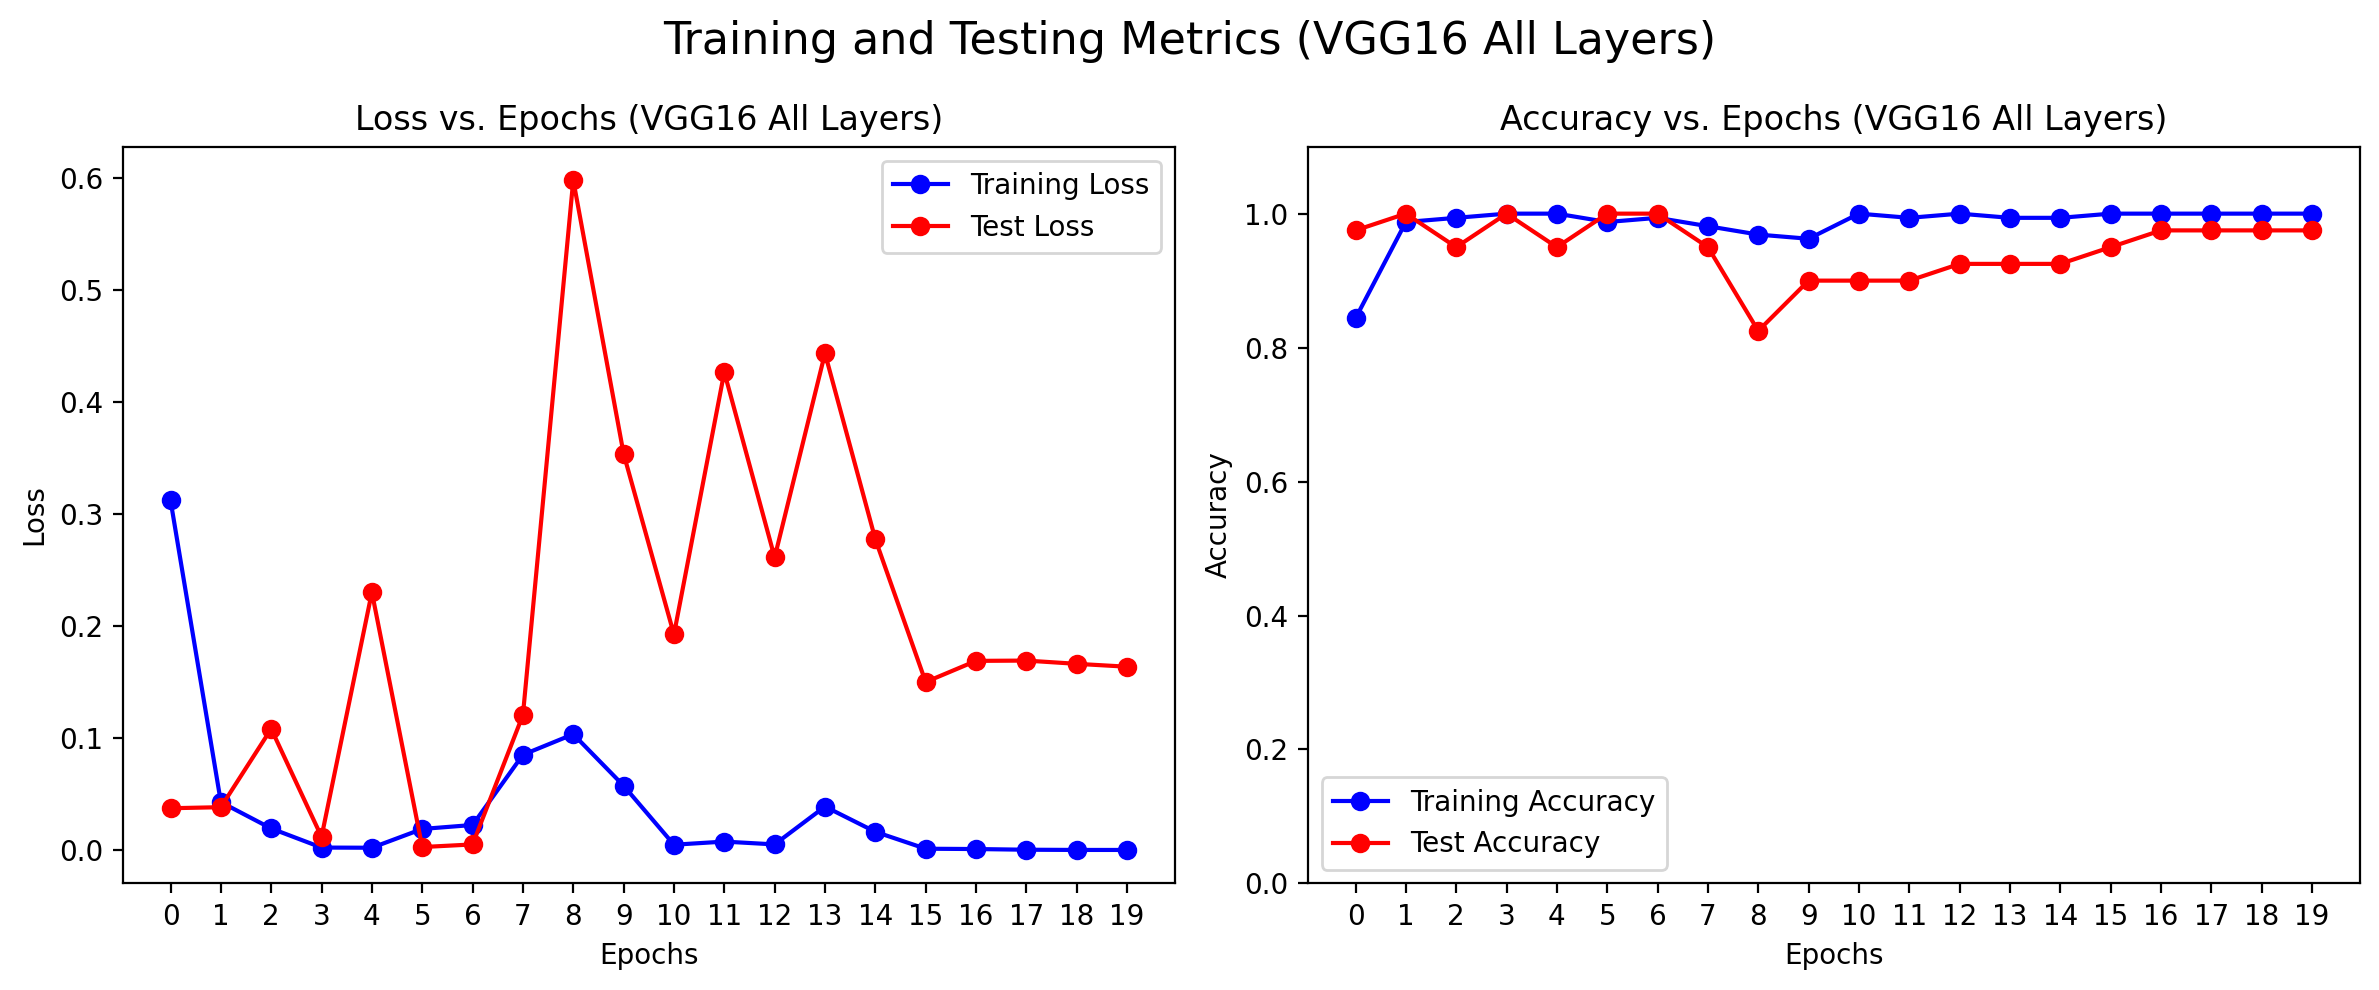

In [17]:
plot_metrics(vgg16_all_layers_train_losses, vgg16_all_layers_test_losses, vgg16_all_layers_train_accuracies, vgg16_all_layers_test_accuracies, 'VGG16 All Layers')

### VGG19 - Finetuning All Layers

In [18]:
vgg19_all_layers, vgg19_all_layers_train_losses, vgg19_all_layers_test_losses, vgg19_all_layers_train_accuracies, vgg19_all_layers_test_accuracies = train_and_evaluate_model(
    vgg19_all_layers, train_loader, test_loader, num_epochs_1, optimizer_vgg19_all_layers, criterion, "VGG19_All_Layers"
)

Epoch [1/20] -> Train Loss: 0.1868, Train Acc: 0.9125, Test Loss: 0.1929, Test Acc: 0.9750
Epoch [2/20] -> Train Loss: 0.0620, Train Acc: 0.9875, Test Loss: 0.0083, Test Acc: 1.0000
Epoch [3/20] -> Train Loss: 0.0464, Train Acc: 0.9875, Test Loss: 0.3163, Test Acc: 0.9000
Epoch [4/20] -> Train Loss: 0.0200, Train Acc: 0.9875, Test Loss: 0.0695, Test Acc: 0.9500
Epoch [5/20] -> Train Loss: 0.1056, Train Acc: 0.9688, Test Loss: 0.1025, Test Acc: 0.9750
Epoch [6/20] -> Train Loss: 0.1660, Train Acc: 0.9500, Test Loss: 0.2322, Test Acc: 0.9250
Epoch [7/20] -> Train Loss: 0.0062, Train Acc: 1.0000, Test Loss: 0.0322, Test Acc: 1.0000
Epoch [8/20] -> Train Loss: 0.0468, Train Acc: 0.9875, Test Loss: 0.4288, Test Acc: 0.9000
Epoch [9/20] -> Train Loss: 0.0283, Train Acc: 0.9938, Test Loss: 0.0096, Test Acc: 1.0000
Epoch [10/20] -> Train Loss: 0.0020, Train Acc: 1.0000, Test Loss: 0.0658, Test Acc: 0.9750
Epoch [11/20] -> Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 0.0110, Test Acc: 1.00

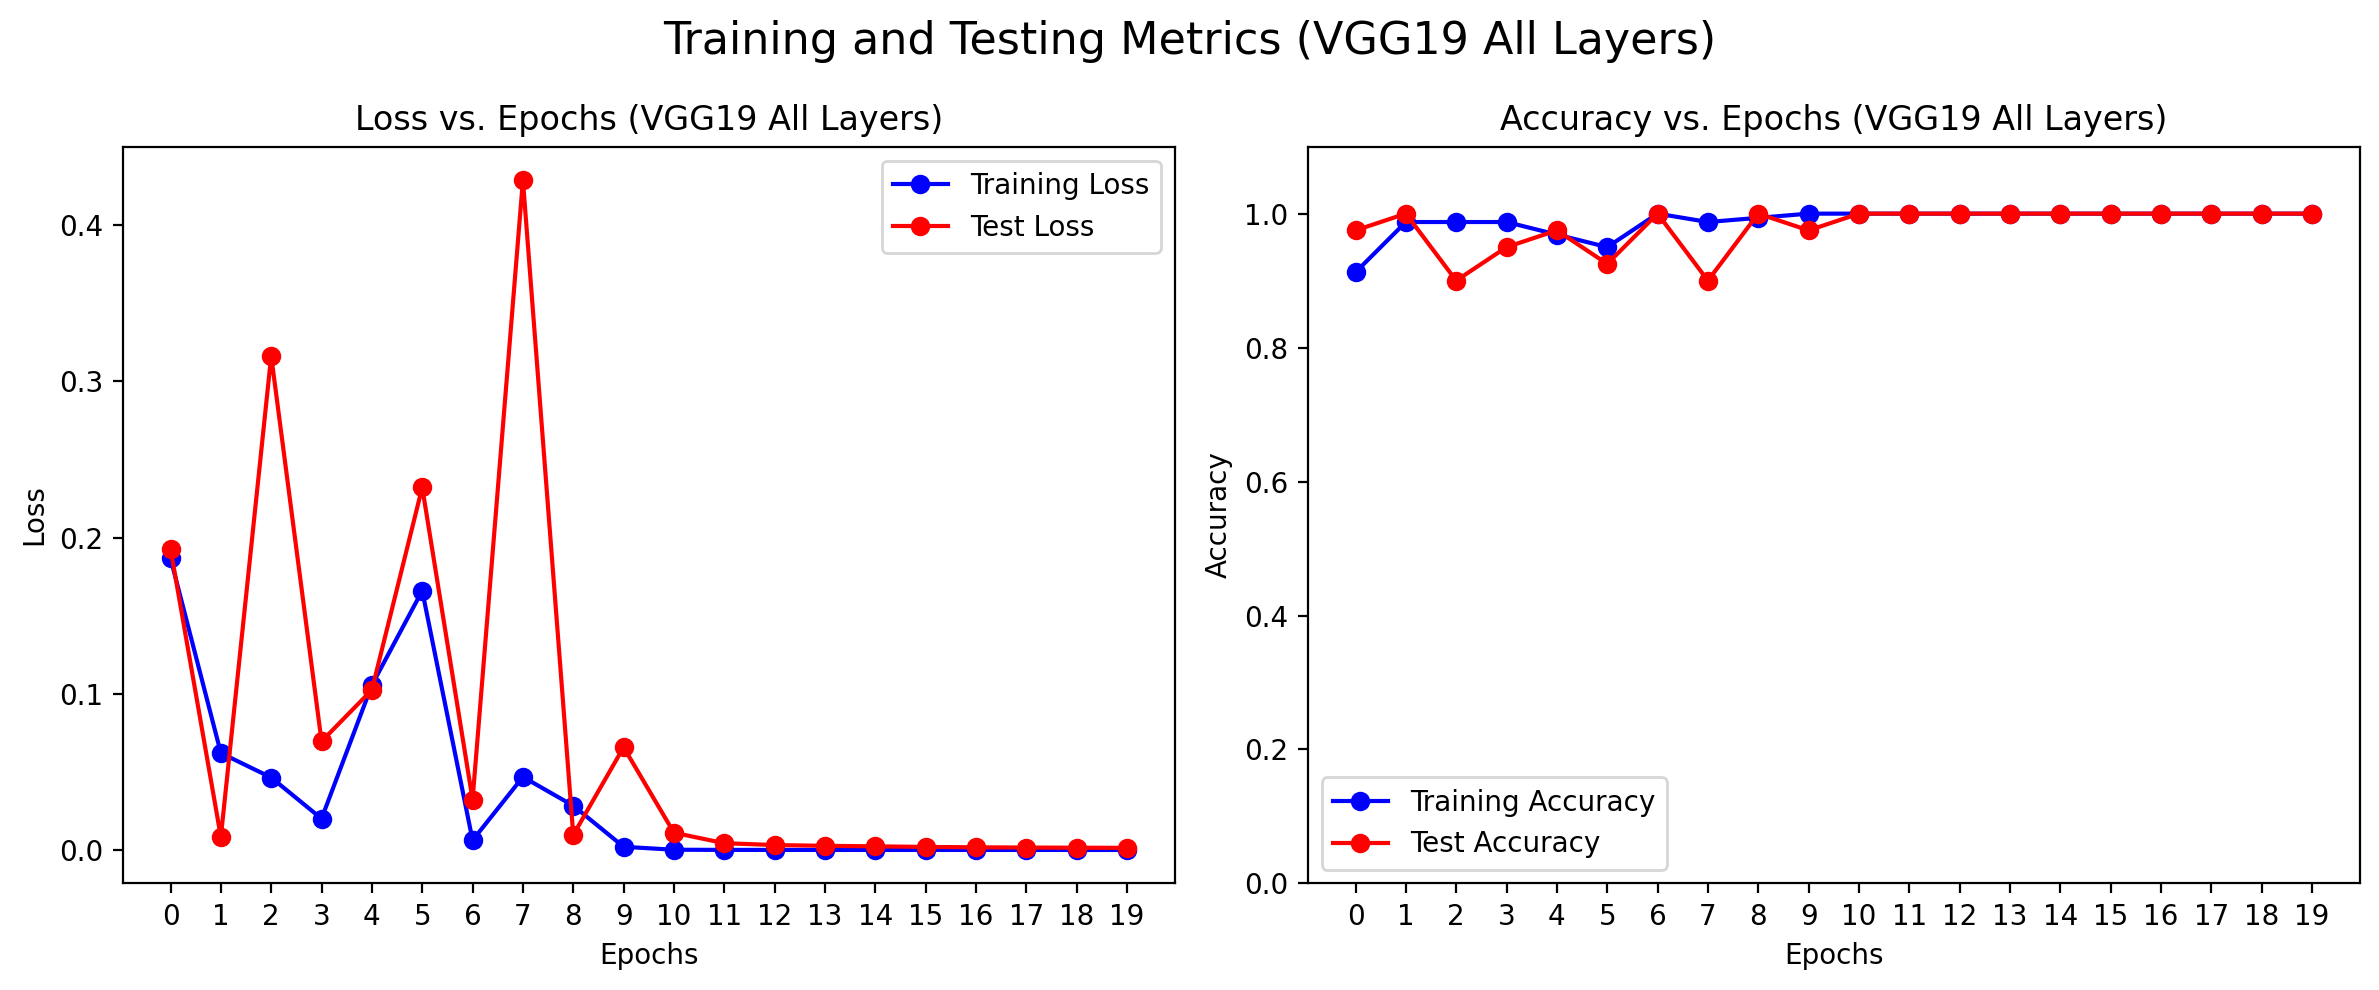

In [19]:
plot_metrics(vgg19_all_layers_train_losses, vgg19_all_layers_test_losses, vgg19_all_layers_train_accuracies, vgg19_all_layers_test_accuracies, 'VGG19 All Layers')

## Transfer learning using VGG16 and VGG19 with tuning only final MLP layers (excluding convolution layers)

### VGG16 - Finetuning Final Layers

In [20]:
vgg16_final_layers, vgg16_final_layers_train_losses, vgg16_final_layers_test_losses, vgg16_final_layers_train_accuracies, vgg16_final_layers_test_accuracies = train_and_evaluate_model(
    vgg16_final_layers, train_loader, test_loader, num_epochs_2, optimizer_vgg16_final_layers, criterion, "VGG16_Final_Layers"
)

Epoch [1/10] -> Train Loss: 0.3049, Train Acc: 0.8688, Test Loss: 0.1056, Test Acc: 0.9500
Epoch [2/10] -> Train Loss: 0.0211, Train Acc: 0.9938, Test Loss: 0.0696, Test Acc: 0.9500
Epoch [3/10] -> Train Loss: 0.0006, Train Acc: 1.0000, Test Loss: 0.0350, Test Acc: 0.9750
Epoch [4/10] -> Train Loss: 0.0004, Train Acc: 1.0000, Test Loss: 0.0441, Test Acc: 0.9750
Epoch [5/10] -> Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 0.0645, Test Acc: 0.9750
Epoch [6/10] -> Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 0.0860, Test Acc: 0.9500
Epoch [7/10] -> Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.1035, Test Acc: 0.9500
Epoch [8/10] -> Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.1130, Test Acc: 0.9500
Epoch [9/10] -> Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.1207, Test Acc: 0.9500
Epoch [10/10] -> Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.1275, Test Acc: 0.9500

---------------------------------
Training complete! Total training time: 66.03 seconds.

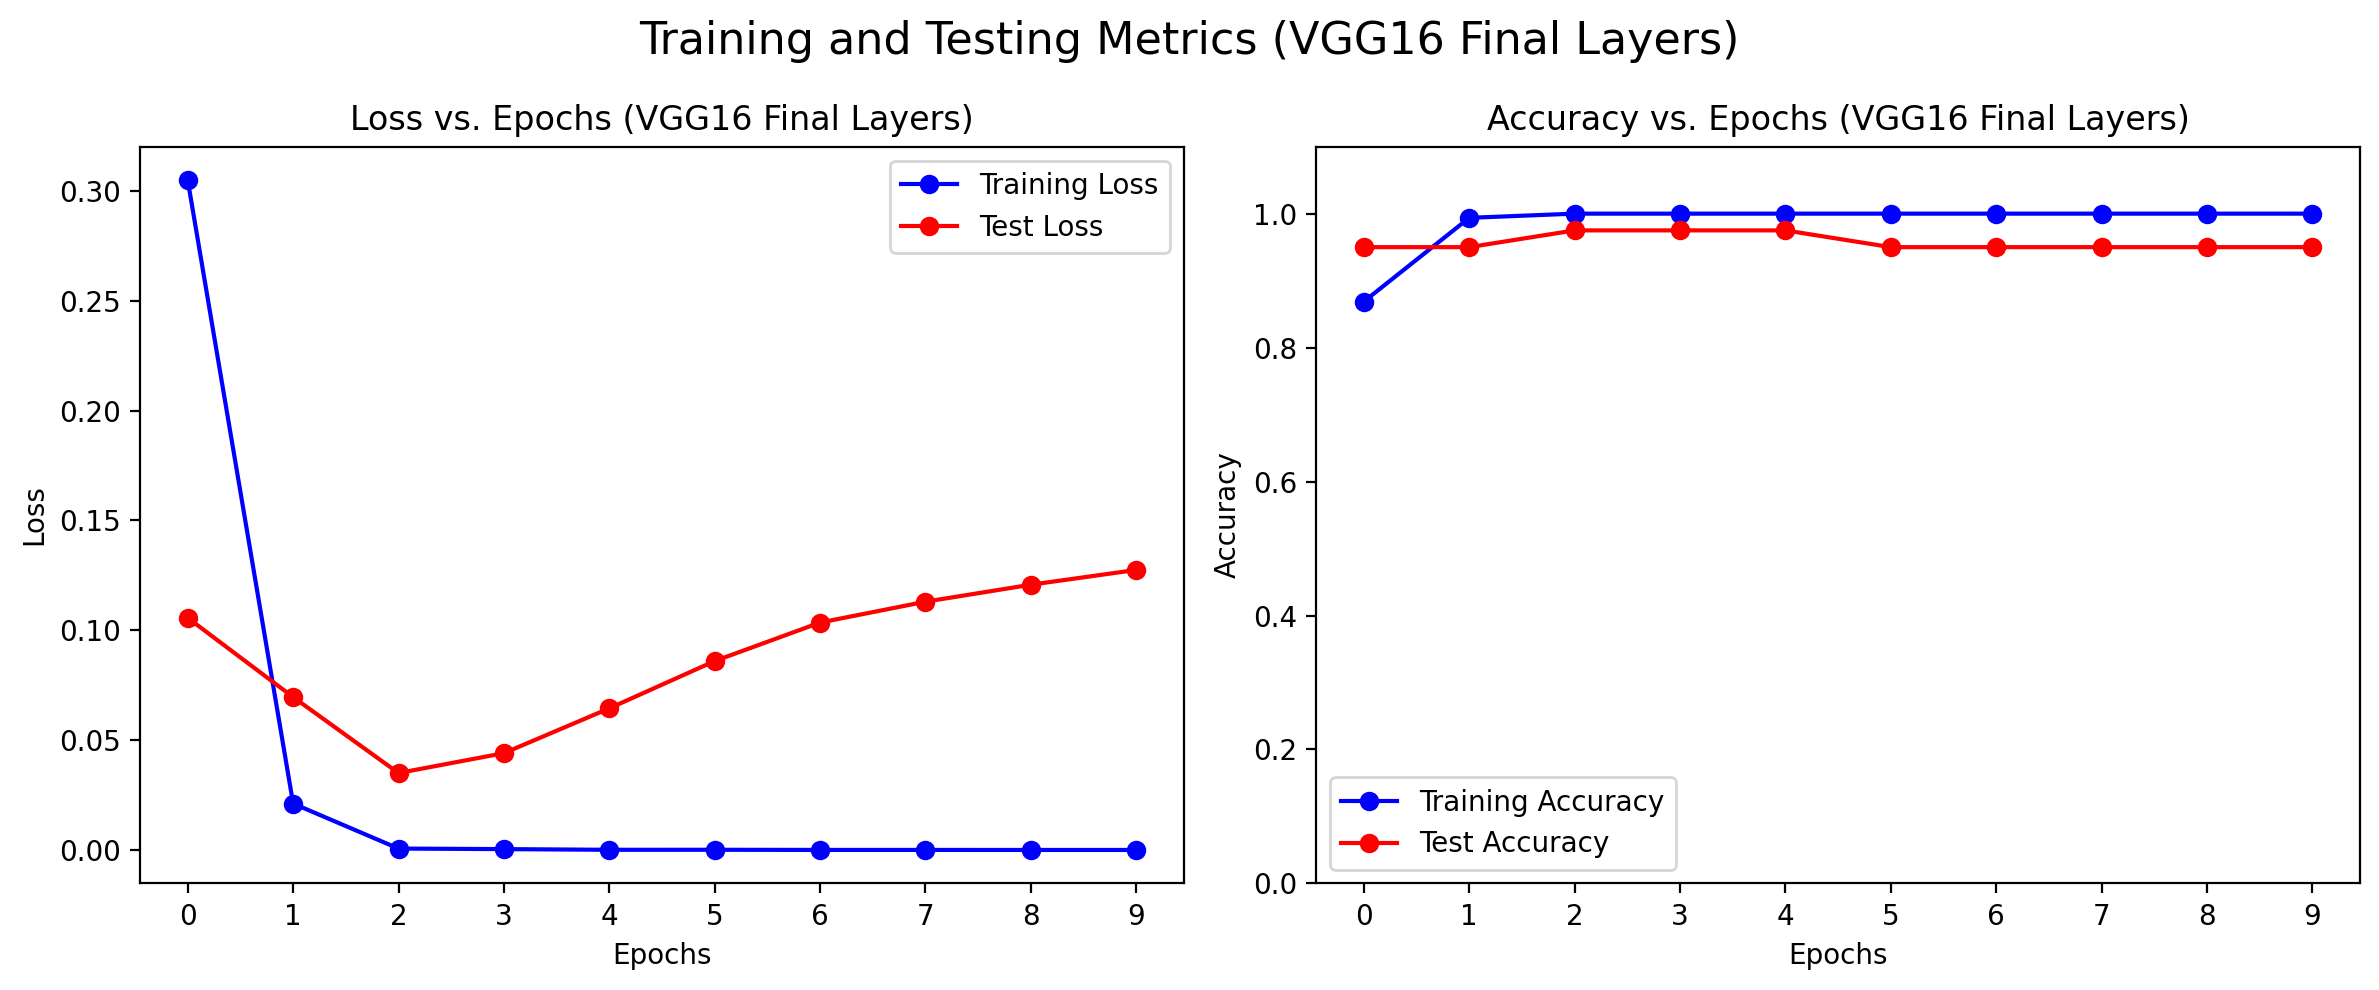

In [21]:
plot_metrics(vgg16_final_layers_train_losses, vgg16_final_layers_test_losses, vgg16_final_layers_train_accuracies, vgg16_final_layers_test_accuracies, 'VGG16 Final Layers')

### VGG19 - Finetuning Final Layers

In [22]:
vgg19_final_layers, vgg19_final_layers_train_losses, vgg19_final_layers_test_losses, vgg19_final_layers_train_accuracies, vgg19_final_layers_test_accuracies = train_and_evaluate_model(
    vgg19_final_layers, train_loader, test_loader, num_epochs_2, optimizer_vgg19_final_layers, criterion, "VGG19_Final_Layers"
)

Epoch [1/10] -> Train Loss: 0.2805, Train Acc: 0.8688, Test Loss: 0.1454, Test Acc: 0.9250
Epoch [2/10] -> Train Loss: 0.0198, Train Acc: 1.0000, Test Loss: 0.0538, Test Acc: 0.9500
Epoch [3/10] -> Train Loss: 0.0041, Train Acc: 1.0000, Test Loss: 0.0288, Test Acc: 1.0000
Epoch [4/10] -> Train Loss: 0.0005, Train Acc: 1.0000, Test Loss: 0.0712, Test Acc: 0.9500
Epoch [5/10] -> Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.1367, Test Acc: 0.9500
Epoch [6/10] -> Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.1741, Test Acc: 0.9500
Epoch [7/10] -> Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.1867, Test Acc: 0.9500
Epoch [8/10] -> Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.1921, Test Acc: 0.9500
Epoch [9/10] -> Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.1925, Test Acc: 0.9500
Epoch [10/10] -> Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.1897, Test Acc: 0.9500

---------------------------------
Training complete! Total training time: 173.87 seconds

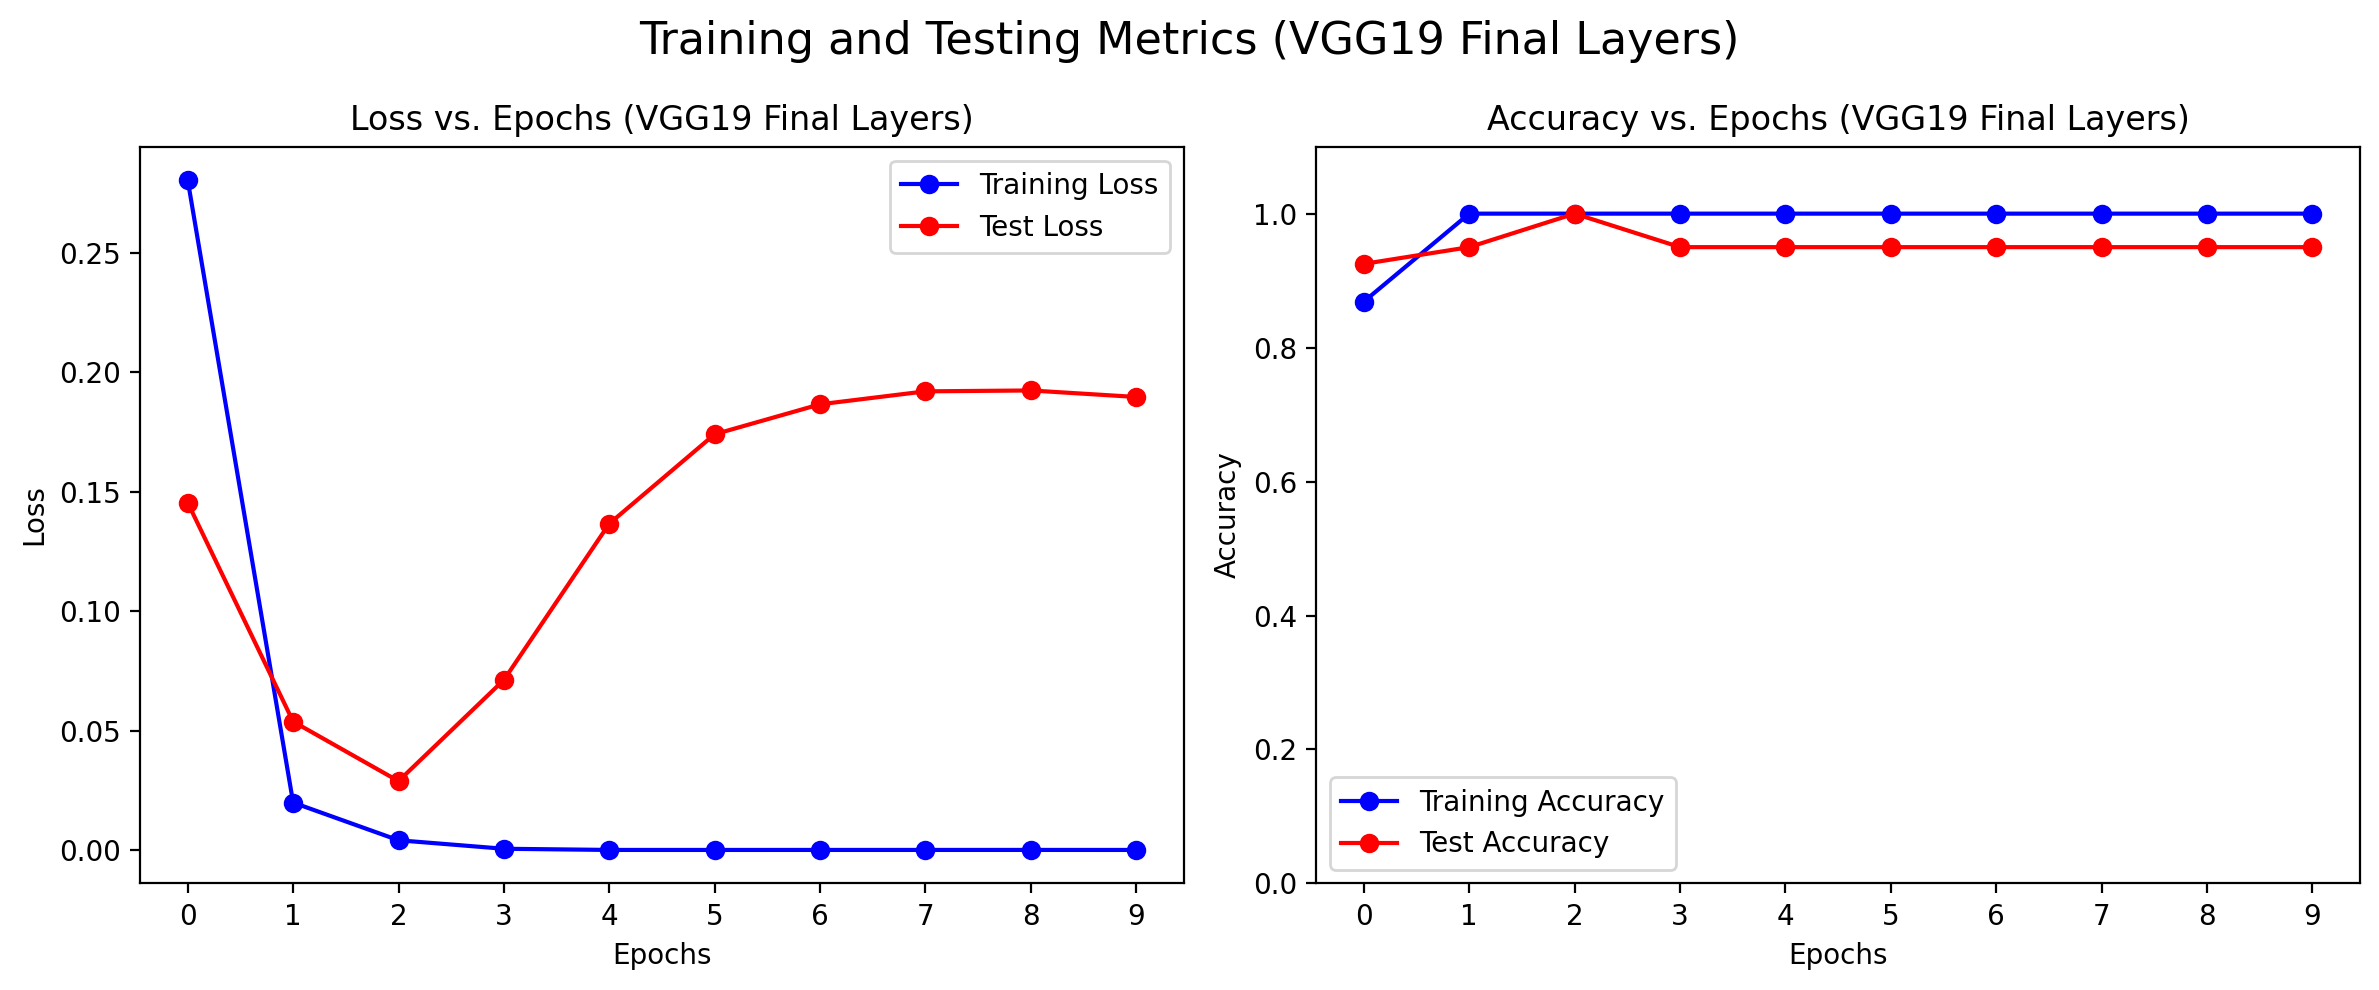

In [23]:
plot_metrics(vgg19_final_layers_train_losses, vgg19_final_layers_test_losses, vgg19_final_layers_train_accuracies, vgg19_final_layers_test_accuracies, 'VGG19 Final Layers')

## Interactive Plots

In [23]:
from ipywidgets import interact, Dropdown, Layout

# Interactive function for confusion matrix plots
def interactive_plot_confusion_matrix(test_loader, device):
    model_options = {
        'VGG16 All Layers': vgg16_all_layers,
        'VGG19 All Layers': vgg19_all_layers,
        'VGG16 Final Layers': vgg16_final_layers,
        'VGG19 Final Layers': vgg19_final_layers
    }
    
    def plot(model_name):
        model = model_options[model_name].to(device)
        plot_confusion_matrix(model, test_loader, title_suffix=model_name, device=device)
    
    dropdown = Dropdown(options=model_options.keys(), description='Model:', layout=Layout(width='400px'))
    interact(plot, model_name=dropdown)


# Interactive function for prediction plots
def interactive_plot_predictions(test_loader, num_images, grid_size, writer, device):
    model_options = {
        'VGG16 All Layers': vgg16_all_layers,
        'VGG19 All Layers': vgg19_all_layers,
        'VGG16 Final Layers': vgg16_final_layers,
        'VGG19 Final Layers': vgg19_final_layers
    }
    
    def plot(model_name):
        model = model_options[model_name].to(device)
        plot_test_predictions_grid(model, test_loader, num_images=num_images, grid_size=grid_size, title_suffix=model_name, device=device, writer=writer)
    
    dropdown = Dropdown(options=model_options.keys(), description='Model:', layout=Layout(width='400px'))
    interact(plot, model_name=dropdown)
    


In [33]:
interactive_plot_confusion_matrix(test_loader, device)

interactive(children=(Dropdown(description='Model:', layout=Layout(width='400px'), options=('VGG16 All Layers'…

In [34]:
interactive_plot_predictions(test_loader, num_images=40, grid_size=(5, 8), writer=None, device=device)

interactive(children=(Dropdown(description='Model:', layout=Layout(width='400px'), options=('VGG16 All Layers'…

## Tensorboard Visualization

In [ ]:
def log_predictions_grid(test_loader, num_images, grid_size, writer, device):
    # Log predictions grid for all models
    models = {
        "VGG16_All_Layers": vgg16_all_layers,
        "VGG19_All_Layers": vgg19_all_layers,
        "VGG16_Final_Layers": vgg16_final_layers,
        "VGG19_Final_Layers": vgg19_final_layers
    }
    for model_name, model in models.items():
        timestamp = datetime.now().strftime("%Y%m%d-%H%M")
        writer = SummaryWriter(f"iter_runs/{model_name}/Test_Predictions_{timestamp}")
        true_labels, predicted_labels = plot_test_predictions_grid(model, test_loader, num_images=num_images, grid_size=grid_size, title_suffix=model_name, device=device, writer=writer, show_plot=False)
    return true_labels, predicted_labels

true_labels, predicted_labels = log_predictions_grid(test_loader, num_images=40, grid_size=(5, 8), writer=None, device=device)

Accuracy on 40 test images: 0.9750
Accuracy on 40 test images: 1.0000
Accuracy on 40 test images: 0.9500
Accuracy on 40 test images: 0.9500


## Save the models

In [16]:
# # Create the models directory if it doesn't exist
# os.makedirs('../models', exist_ok=True)

# # Save the models
# torch.save(vgg16_all_layers.state_dict(), '../models/vgg16_all_layers.pth')
# torch.save(vgg16_final_layers.state_dict(), '../models/vgg16_final_layers.pth')
# torch.save(vgg19_all_layers.state_dict(), '../models/vgg19_all_layers.pth')
# torch.save(vgg19_final_layers.state_dict(), '../models/vgg19_final_layers.pth')

# Load the models
vgg16_all_layers.load_state_dict(torch.load('../models/vgg16_all_layers.pth'))
vgg16_final_layers.load_state_dict(torch.load('../models/vgg16_final_layers.pth'))
vgg19_all_layers.load_state_dict(torch.load('../models/vgg19_all_layers.pth'))
vgg19_final_layers.load_state_dict(torch.load('../models/vgg19_final_layers.pth'))


<All keys matched successfully>

In [17]:
vgg16_all_layers_acc, _, _ = predict(vgg16_all_layers, test_loader, device)
vgg16_final_layers_acc, _, _ = predict(vgg16_final_layers, test_loader, device)
vgg19_all_layers_acc, _, _ = predict(vgg19_all_layers, test_loader, device)
vgg19_final_layers_acc, _, _ = predict(vgg19_final_layers, test_loader, device)

print(f"VGG16 All Layers Test Accuracy: {vgg16_all_layers_acc * 100:.2f}%")
print(f"VGG19 All Layers Test Accuracy: {vgg19_all_layers_acc * 100:.2f}%")
print(f"VGG16 Final Layers Test Accuracy: {vgg16_final_layers_acc * 100:.2f}%")
print(f"VGG19 Final Layers Test Accuracy: {vgg19_final_layers_acc * 100:.2f}%")

VGG16 All Layers Test Accuracy: 97.50%
VGG19 All Layers Test Accuracy: 100.00%
VGG16 Final Layers Test Accuracy: 97.50%
VGG19 Final Layers Test Accuracy: 95.00%


## Predicting on AI generated images

In [18]:
# Define the path to your test images
test_dir = "../generated_images"

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for consistency
    transforms.ToTensor(),           # Convert to tensor for processing
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.215])

])

# Create the dataset using ImageFolder
gen_test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
print("Total test samples:", len(gen_test_dataset))

# Define the DataLoader
gen_test_loader = DataLoader(gen_test_dataset, batch_size=32, shuffle=False)  # Set shuffle=False for test data

# Verify the dataset class names
print("Class names:", gen_test_dataset.classes)  # This should output ['Sparrow', 'Swan']

Total test samples: 20
Class names: ['Sparrow', 'Swan']


In [19]:
gen_vgg16_all_layers_acc, _, _ = predict(vgg16_all_layers, gen_test_loader, device)
gen_vgg16_final_layers_acc, _, _ = predict(vgg16_final_layers, gen_test_loader, device)
gen_vgg19_all_layers_acc, _, _ = predict(vgg19_all_layers, gen_test_loader, device)
gen_vgg19_final_layers_acc, _, _ = predict(vgg19_final_layers, gen_test_loader, device)

print(f"VGG16 All Layers Test Accuracy on Generated Images: {gen_vgg16_all_layers_acc * 100:.2f}%")
print(f"VGG19 All Layers Test Accuracy on Generated Images: {gen_vgg19_all_layers_acc * 100:.2f}%")
print(f"VGG16 Final Layers Test Accuracy on Generated Images: {gen_vgg16_final_layers_acc * 100:.2f}%")
print(f"VGG19 Final Layers Test Accuracy on Generated Images: {gen_vgg19_final_layers_acc * 100:.2f}%")

VGG16 All Layers Test Accuracy on Generated Images: 100.00%
VGG19 All Layers Test Accuracy on Generated Images: 95.00%
VGG16 Final Layers Test Accuracy on Generated Images: 100.00%
VGG19 Final Layers Test Accuracy on Generated Images: 100.00%


In [24]:
interactive_plot_confusion_matrix(gen_test_loader, device)

interactive(children=(Dropdown(description='Model:', layout=Layout(width='400px'), options=('VGG16 All Layers'…

In [ ]:
interactive_plot_predictions(gen_test_loader, num_images=20, grid_size=(5, 4), writer=None, device=device)

interactive(children=(Dropdown(description='Model:', layout=Layout(width='400px'), options=('VGG16 All Layers'…